### Read SCREAM CESS data
Andrew Gettelman, Feb 2025

In [1]:
import healpix as hp
import numpy as np
import xarray as xr
import intake
import numcodecs
import zarr

import easygems.healpix as egh
import easygems.remap as egr

import matplotlib.pyplot as plt

import dask.array as da

import glob

### Basic Data parameters

	0. output.scream.Cess.50hourly_QcQiNcNi.INSTANT.nhours_x50.*
		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
		- nc, ni, qc, qi
	1. output.scream.Cess.50hourly_QrNrQmBm.INSTANT.nhours_x50.2020-08-31-72000.nc
		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
		- bm, nr, qm, qr. (What is 'm'? Mixed? What is variable bm?)
	2. output.scream.Cess.hourly2DVars.INSTANT.nhours_x1.*
		- 49 times, hourly, raw 3km output (25M columns)
		- Precip, olr
	3. output.scream.Cess.6hourlyINST_ne30.INSTANT.nhours_x6.2020-08-31-21600.nc
		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels
		- 2D: IWP, LWP, RH, T_2m, WV_path, ps, 
		- 3D: T_mid,horiz winds (dim2=U.v?), omega, O3, qc, qv, tke
		- Static: landfrac, oceanfrac
	4. output.scream.Cess.6hourlyAVG_ne30.AVERAGE.nhours_x6.2020-08-31-00000.nc
		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels (don't need them)
		- Lots of low res variables
    5. 3hourlyAVG_ne120.AVERAGE.nhours_x3.
        - Ne120 (25km), 3hrly, 221 levels
        - 2D and 3D variables
    6. cess-oct2.elm.h1.
        - Daily land output on native land grid (swe, soil moisture)

In [2]:
### Path and data sets

#rfn='cess-control.ne1024pg2_ne1024pg2.F2010-SCREAMv1.cess-oct2/run/'
#fn='/global/cfs/cdirs/e3sm/gsharing/EAMxx/Cess/SCREAM3km/'+rfn

fn='/pscratch/sd/a/agett/scream/cess-copy/'

### Prefixes for 'Streams'

outpre='output.scream.Cess.'

fprefix=[]

fprefix.append('50hourly_QcQiNcNi.INSTANT.nhours_x50.')
#		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
#		- nc, ni, qc, qi

fprefix.append('50hourly_QrNrQmBm.INSTANT.nhours_x50.')
#		- 128 levels, 1 time sample, raw 3km SCREAM grid (25M columns)
#		- bm, nr, qm, qr. (What is 'm'? Mixed? What is variable bm?)

fprefix.append('hourly2DVars.INSTANT.nhours_x1.')
#		- 49 times, hourly, raw 3km output (25M columns)
#		- Precip, olr

fprefix.append('6hourlyINST_ne30.INSTANT.nhours_x6.')
#		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels
#		- 2D: IWP, LWP, RH, T_2m, WV_path, ps, 
#		- 3D: T_mid,horiz winds (dim2=U.v?), omega, O3, qc, qv, tke
#		- Static: landfrac, oceanfrac

fprefix.append('6hourlyAVG_ne30.AVERAGE.nhours_x6.')
#		- Ne 30 (1deg), 4 times, 6 hourly, 221 levels (don't need them)
#		- Needed variables (All 2D): LW flux at bot (up,down), LW flux up at top, SW dwn/up at top/bot (4)
#            horiz wind at bottom (U,V), ice_precip, liq_precip, ps, surf_evap, surf_mom (u,v), surf_T, 
#            surf sens_flux, upward LHF

fprefix.append('3hourlyAVG_ne120.AVERAGE.nhours_x3.')
#       - Ne 120 (25km), 24 times, 3 hourly, 221 levels
#       - Lots of variables could be used here (2D rad fluxes, Tmp, precip, ps) (3D qc,qi,qr,qv,z,omega, winds)
#       - most of what is needed is here!

fprefix.append('cess-control.ne1024pg2_ne1024pg2.F2010-SCREAMv1.cess-oct2.elm.h1.')
#       - Daily land files on native land grid (25M columns): H2OSNO, SOILWATER_10CM

s=2

In [3]:
s=2

if (s==6):
    fspec=fn+fprefix[s]+'*.nc'
else:
    fspec=fn+outpre+fprefix[s]+'*.nc'

file_list= glob.glob(fspec)

# Sort it by time
sorted_files = sorted(file_list)


In [4]:
fspec

'/pscratch/sd/a/agett/scream/cess-copy/output.scream.Cess.hourly2DVars.INSTANT.nhours_x1.*.nc'

In [5]:
%%time
## Issues: 
# for ne30 data (s=3 and 4) one file has a day extra data (one file is 2 days apart, but has 3 days of data)
## So load it twice, and then append...

## Still issues with hourly data on native grid (s=2) [need to sort that out]. 

if (s == 5):
    del sorted_files[70]
    ds0=xr.open_mfdataset(sorted_files[:69])
    ds1=xr.open_mfdataset(sorted_files[69:])
    ds_scream=xr.concat([ds0,ds1.isel(time=slice(8,1536))],dim='time')
    del ds0,ds1
    
if (s == 3) or (s==4):
    ds0=xr.open_mfdataset(sorted_files[:69])
    ds1=xr.open_mfdataset(sorted_files[69:])
    ds_scream=xr.concat([ds0,ds1.isel(time=slice(4,1529))],dim='time')
    del ds0,ds1

if (s < 2) or (s==6):
    ds_scream=xr.open_mfdataset(sorted_files)

if (s==2):
    ### Clean up for hourly
# remove some files with zero timestep
    rmf={22,72,77,83}
    new_sort=[item for idx, item in enumerate(sorted_files) if idx not in rmf]

# Now have to handle 'extra days'
    ds0=xr.open_mfdataset(new_sort[0:21])
    ds1=xr.open_mfdataset(new_sort[21:74])
    ds2=xr.open_mfdataset(new_sort[74:79])
    
    ds3=xr.open_mfdataset(new_sort[79:107])    
    ds_scream=xr.concat([ds0,ds1.isel(time=slice(48,None)),ds2.isel(time=slice(48,None)),ds3.isel(time=slice(48,None))],dim='time')
    del ds0,ds1,ds2,ds3

# Test
#    ds_scream=xr.open_mfdataset(new_sort[58:64])  #Sample files in-situ
#    ds_scream=xr.open_mfdataset(sorted_files)  #Sample files scratch

OSError: no files to open

In [6]:
ds_scream

NameError: name 'ds_scream' is not defined

### Vertical Information

In [ ]:
### Vertical Levels for s=3,5 (221)
#levfile='/global/cfs/cdirs/e3sm/gsharing/EAMxx/Cess/SCREAM3km/grids/vrt_remapping_p_levs_20230926.nc'
#slev=xr.open_dataset(levfile)

In [ ]:
### Vertical levels to interpolate to.
#tr = np.arange(100,900,100)
#lt = np.arange(850,1025,25)
#ua = np.arange(10,90,20)
#levels = sorted({1,5,20,150,250,750}.union(tr,lt,ua))
#levels = [int(x) for x in levels]

In [ ]:
#ds_scream=ds_scream.assign_coords({"lev":slev.p_levs.values/100.})

In [ ]:
#ds_scream=ds_scream.interp(lev=levels)

In [ ]:
# Do this once for each stream to get a list of things in the file
#list(ds_scream.keys())

### Process data
Try first with 2-D fields

In [7]:
if(s==3):
    varn2D=['IceWaterPath','LiqWaterPath','VapWaterPath','T_2m','landfrac','ocnfrac',
            'qv_2m','surf_radiative_T','ps']
    varn3D=['T_mid','omega','RelativeHumidity','qc','qi','qr','qv','tke']
    varn4D=['horiz_winds']

if(s==5):
    varn2D=['LW_clrsky_flux_dn_at_model_bot','LW_clrsky_flux_up_at_model_top', 'LW_flux_dn_at_model_bot',
            'LW_flux_up_at_model_bot','LW_flux_up_at_model_top','LongwaveCloudForcing',
            'SW_clrsky_flux_dn_at_model_bot','SW_clrsky_flux_up_at_model_bot','SW_clrsky_flux_up_at_model_top',
            'SW_flux_dn_at_model_bot','SW_flux_dn_at_model_top','SW_flux_up_at_model_bot',
            'SW_flux_up_at_model_top','ShortwaveCloudForcing',
            'T_2m','precip_ice_surf_mass_flux','precip_liq_surf_mass_flux','ps',
            'sfc_flux_lw_dn','sfc_flux_sw_net','surf_evap','surf_radiative_T',
            'surf_sens_flux','surface_upward_latent_heat_flux','qv_at_model_bot']
# Mapping names
    varn2Dout=['rldscs','rlutcs', 'rlds',
            'rlus','rlut','lwcre',
            'rsdscs','rsuscs','rsutcs',
            'rsds','rsdt','rsus',
            'rsut','swcre',
            'tas','prs','pr','ps',
            'sfc_flux_lw_dn','sfc_flux_sw_net','surf_evap','ts',
            'hfssd','hflsd','huss']
    
    varn2Dvec=['horiz_winds_at_model_bot','surf_mom_flux']

    varn2DvecOut=['uas','vas','tauu','tauv']
    
    varn3D=['T_mid','omega','qc','qv','z_mid','cldfrac_tot']

    varn3Dout=['ta','omega','qall','hus','zg','cl']  #qall=qc+qi+qr
    
    varn3Dvec=['horiz_winds']

    varn3DvecOut=['ua','va']
    
if(s==6):
    varn2D=['H2OSNO','SOILWATER_10CM']
    varn2Dout=['swe','mrso']

if(s==2):
    varn2D=['LW_flux_up_at_model_top','precip_total_surf_mass_flux']
    varn2Dout=['rlut','pr']

In [ ]:
#Rename variables

# Create rename mapping
rename_dict = dict(zip(varn2D, varn2Dout))

ds_scream=ds_scream.rename(rename_dict)

In [ ]:
ds_scream

In [ ]:
### Select Variable
v=0
ds_scream[varn2Dout[v]]

### Helper Functions for Zarr Encoding

In [8]:
# Single Precision for Floats

def get_dtype(da):
    if np.issubdtype(da.dtype, np.floating):
        return "float32"
    else:
        return da.dtype
    
    
# Chunking (note, 'cell' has to match name of column dimension in input)

def get_chunks(dimensions):
    if "level" in dimensions:
        chunks = {
            "time": 24,
            "cell": 4**6,
            "level": 4,
        }
    else:
        chunks = {
            "time": 48,
            "cell": 4**6,
        }

    return tuple((chunks[d] for d in dimensions))

# Compression

def get_compressor():
    return numcodecs.Blosc("zstd", shuffle=2)

In [9]:
#Loop over all variables and create encoding directory...

def get_encoding(dataset):
    return {
        var: {
            "compressor": get_compressor(),
            "dtype": get_dtype(dataset[var]),
            "chunks": get_chunks(dataset[var].dims),
        }
        for var in dataset.variables
        if var not in dataset.dims
    }

### Create a HealPix Grid or read Pre-calculated weights

In [ ]:
#%%time
#
#s='6'
#order = zoom = int(s)
#nside = hp.order2nside(order)
#npix = hp.nside2npix(nside)
#
#write = True
#
#if write:
#
#    hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
#    hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
#    hp_lon += 360 / (4 * nside) / 4  # shift quarter-width
#
#    slon=(ds_scream.lon.isel(time=0) + 180) % 360 - 180  # [-180, 180)
#
#    eweights = egr.compute_weights_delaunay((slon, ds_scream.lat.isel(time=0)), (hp_lon, hp_lat))
#
## You can also save the calculated weights for future use
#    eweights.to_netcdf("scream_ne30_healpix_weights"+s+".nc")

#else: 
#    eweights=xr.open_dataset("/global/u1/a/agett/python/hackathon/scream_ne30_healpix_weights"+s+".nc") 


### Version 2 designed to work with ne30 lower resolution grid
From Lukas Kluft

The idea is to create an extended version of the grid by padding it with itself, but shifted to the east and west. 
Then the triangulation weights can be computed without any gaps. 
In a final step, the extended index values can be mapped back to the original source index. 
The resulting weights can then be used as before. 


In [ ]:
%%time
#Version 2

s='10'
order = zoom = int(s)
nside = hp.order2nside(order)
npix = hp.nside2npix(nside)

write = False

if write:

    hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
    hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
    hp_lon += 360 / (4 * nside) / 4  # shift quarter-width


    slon=ds_scream.lon.isel(time=0)
    slat=ds_scream.lat.isel(time=0)
    
# Periodically extend longitude to the east and west
    lon_periodic = np.hstack((slon - 360, slon, slon + 360))
    lat_periodic = np.hstack((slat, slat, slat))

# Compute weights
    eweights = egr.compute_weights_delaunay(
        points=(lon_periodic, lat_periodic),
        xi=(hp_lon, hp_lat)
    )

# Remap the source indices back to their valid range
    eweights = eweights.assign(src_idx=eweights.src_idx % slat.size)

# Save the calculated weights for future use
    eweights.to_netcdf("scream_ne1024_healpix_weights"+s+".nc")

else: 
    eweights=xr.open_dataset("/global/u1/a/agett/python/hackathon/scream_ne1024_healpix_weights"+s+".nc") 


In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

In [ ]:
### Rewrite from Jill Zhang
def custom_indexing(ds_var, src_idx, weights, valid):
    # Perform the advanced indexing in a NumPy context
    return np.where(
        valid,
        (ds_var[src_idx] * weights).sum(axis=-1),
        np.nan
    )

In [ ]:
%%time

### Fast way from Jill Zhang

valid = eweights["valid"]
src_idx = eweights["src_idx"]
weights = eweights["weights"]
 
# Use map_blocks to apply the function on Dask chunks
rewrite = da.map_blocks(
    custom_indexing,
    ds_scream[varn2Dout[v]].isel(time=10), src_idx, weights, valid,
    dtype=float  # Specify output dtype
)
egh.healpix_show(rewrite.compute())

### Remap The full data set
Use xarray’s apply_ufunc() function to lift the function onto a full dataset

In [ ]:
%%time
### SCREAM version

# if the dataset contains coordinates, then remove them 
if 'hyam' in ds_scream.variables:
    ds_scream_sm=ds_scream.drop_vars(['hyai','hybi','hyam','hybm'])

scream_remap = xr.apply_ufunc(
    egr.apply_weights,
    ds_scream[[varn2Dout[v]]],
    kwargs=eweights,
    keep_attrs=True,
    input_core_dims=[["ncol"]],
    output_core_dims=[["cell"]],
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"cell": npix},
    },
)
scream_remap

### Store coordinate Reference System

In [ ]:
scream_remap["crs"] = xr.DataArray(
    name="crs",
    data=[],
    dims="crs",
    attrs={
        "grid_mapping_name": "healpix",
        "healpix_nside": 2**zoom,
        "healpix_order": "nest",
    },
)

### Write to Zarr 

In [ ]:
%%time
# 1 year of 2D level 8 (25km) @3 hrly = 12GB, 2m38s
# 1 year of hourly 2 D level 10 (6km) = 25-30GB peak mem, but 'hours'
#12 days hourly 2D level 10 = 2 min

opth='/pscratch/sd/a/agett/hackathon_zarr_singles/'

ofn=opth+"scream2D_hrly_"+varn2Dout[v]+"_hp"+z+"_v6.zarr"

store = zarr.storage.DirectoryStore(ofn, dimension_separator="/")
scream_remap.chunk({"time": 24, "cell": 4**6}).to_zarr(store, encoding=get_encoding(scream_remap))

### Test Read Back

In [20]:
%%time
#v=1
#z='7'
opth='/pscratch/sd/a/agett/hackathon_zarr_singles/'
ofn=opth+"scream2D_hrly_"+varn2Dout[v]+"_hp"+z+"_v6.zarr"

#ds2=xr.open_dataset(ofn,chunks={"time":48,"cell": 4**6}) # Needed for large data sets (Writing,9,8, maybe 7)
ds2=xr.open_dataset(ofn) # This is better for level 7 or so and below.

CPU times: user 14.9 ms, sys: 5.41 ms, total: 20.4 ms
Wall time: 21.1 ms


/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


### Write other resolutions

In [ ]:
ds2

In [12]:
import gc

In [21]:
%%time
# Now Loop (max memory with the correct cell chunking on read is now only 12GB for level 9...)
dn=ds2
#del ds2
for x in range(6,-1,-1):
#for x in range(9,6,-1):
    z=str(x)
    fn="scream2D_hrly_"+varn2Dout[v]+"_hp"+z+"_v6.zarr"
    print(fn)
    dx=dn.coarsen(cell=4).mean()
    dx['crs'].attrs['healpix_nside'] = 2**int(z)   # Update HEALPix level metadata
    store = zarr.storage.DirectoryStore(opth+fn, dimension_separator="/")
    dx.chunk({"time": 48, "cell": 4**6}).to_zarr(store, encoding=get_encoding(dx))
    dn=dx
    del dx,store
    gc.collect()

#del dn,dx

scream2D_hrly_pr_hp6_v6.zarr
scream2D_hrly_pr_hp5_v6.zarr
scream2D_hrly_pr_hp4_v6.zarr
scream2D_hrly_pr_hp3_v6.zarr
scream2D_hrly_pr_hp2_v6.zarr
scream2D_hrly_pr_hp1_v6.zarr
scream2D_hrly_pr_hp0_v6.zarr
CPU times: user 1min 10s, sys: 17.5 s, total: 1min 28s
Wall time: 50.2 s


### Plot Any Resolution

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

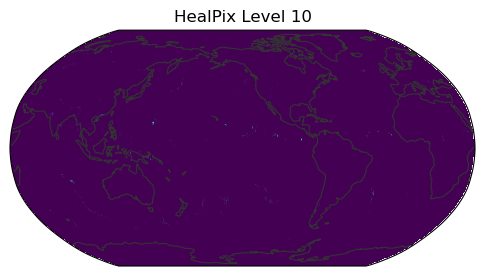

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

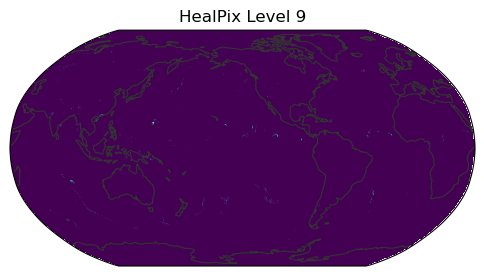

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

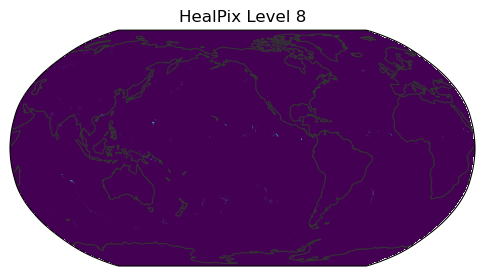

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

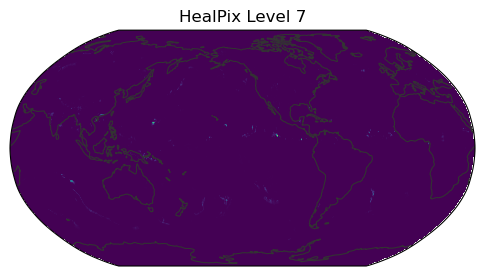

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

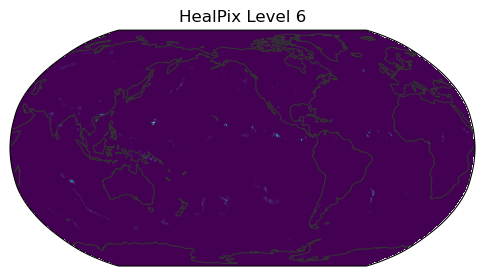

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

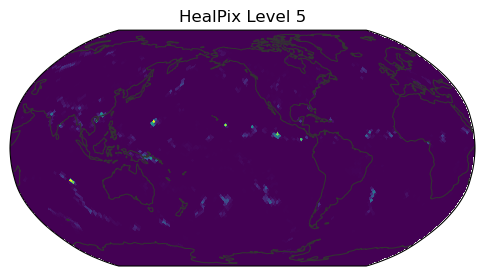

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

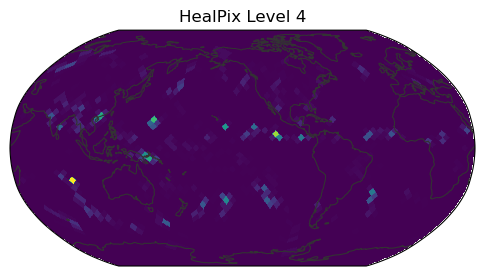

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

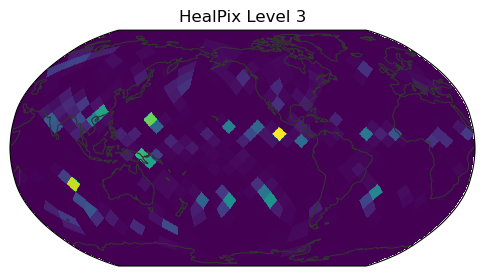

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

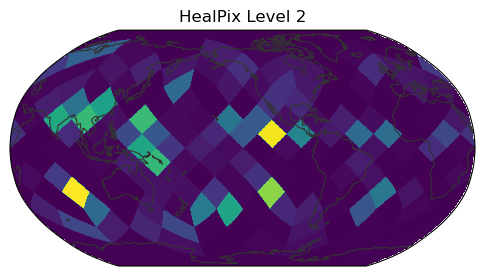

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

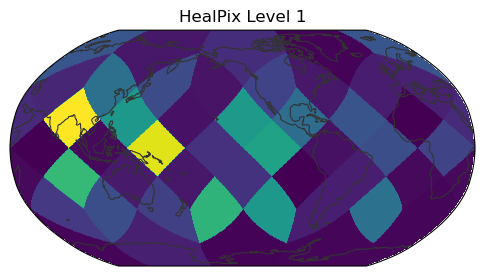

/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/global/homes/a/agett/.conda/envs/analysis4a/lib/python3.12/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Figure size 600x400 with 0 Axes>

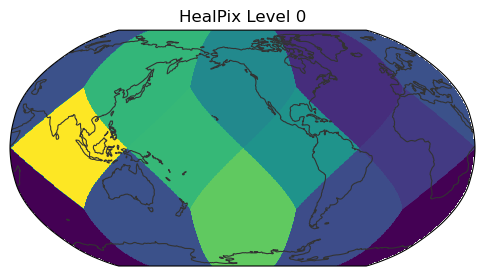

CPU times: user 3.2 s, sys: 1.69 s, total: 4.89 s
Wall time: 6.59 s


In [23]:
%%time
plt.rcParams['figure.figsize'] = [6, 4]

v=1
for x in range(10,-1,-1):
    s=str(x)
    fn=opth+"scream2D_hrly_"+varn2Dout[v]+"_hp"+s+"_v6.zarr"
    ds=xr.open_dataset(fn)
    egh.healpix_show(ds[varn2Dout[v]].isel(time=1))
    plt.title('HealPix Level '+s)
    plt.show()
    del ds